In [2]:
import os

# Dosya yolunu tanımlayalım
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
# Dosyaların çıkarılacağı hedef klasör (Colab yerel diski)
DEST_PATH = '/content/uclm_data'

# Hedef klasör yoksa oluşturalım
if not os.path.exists(DEST_PATH):
    os.makedirs(DEST_PATH)

# Unzip komutu (-q parametresi çıktıları gizleyerek işlemi hızlandırır)
!unzip -q "{ZIP_PATH}" -d "{DEST_PATH}"

print("İşlem tamamlandı! Dosyalar şu klasöre çıkarıldı:", DEST_PATH)

İşlem tamamlandı! Dosyalar şu klasöre çıkarıldı: /content/uclm_data


In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. AYARLAR ---
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
EXTRACT_PATH = '/content/uclm_tl_train'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NEW_LEARNING_RATE = 0.0001 # LR 10^-5 olarak güncellendi
EPOCHS = 50

# --- 2. ZIP'TEN ÇIKARMA ---
if not os.path.exists(EXTRACT_PATH):
    print("📦 TL Verileri zip'ten çıkarılıyor...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ Çıkarma tamamlandı.")

# --- 3. VERİ YÜKLEYİCİLER ---
train_dir = os.path.join(EXTRACT_PATH, 'train')
val_dir = os.path.join(EXTRACT_PATH, 'val')

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 4. MODEL TANIMI (Fine-Tuning Modu) ---
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Son 20 katmanı eğitime açıyoruz
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('/content/best_resnet_tl.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

# --- 6. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"\n🚀 ResNet50 Fine-Tuning Başlıyor (Son 20 Katman Açık, LR: {NEW_LEARNING_RATE})...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# --- 7. DRIVE'A KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/"
if not os.path.exists(save_dir): os.makedirs(save_dir)

model_path = os.path.join(save_dir, "resnet50_uclm_tl(-4).keras")
model.save(model_path)
print(f"✅ Model kaydedildi: {model_path}")

📦 TL Verileri zip'ten çıkarılıyor...
✅ Çıkarma tamamlandı.
Found 2121 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 ResNet50 Fine-Tuning Başlıyor (Son 20 Katman Açık, LR: 0.0001)...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.3766 - loss: 1.2073
Epoch 1: val_accuracy improved from -inf to 0.12745, saving model to /content/best_resnet_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 72s 804ms/step - accuracy: 0.3773 - loss: 1.2062 - val_accuracy: 0.1275 - val_loss: 1.8016 - learning_rate: 1.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5473 - loss: 0.9470
Epoch 2: val_accuracy did not improve from 0.12745
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 548ms/step - accuracy: 0.5473 - loss: 0.9471 - val_accuracy: 0.1275 - val_loss: 1.5029 - learning_rate: 1.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5882 - loss: 0.8745
Epoch 3: val_accuracy did not improve from 0.12745
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 551ms/step - accuracy: 0.5881 - loss: 0.8746 - val_accuracy: 0.1275 - val_loss: 1.2201 - learning_rate: 1.0000e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6266 - loss: 0.8084
Epoch 4: val_accu

✅ Model Drive'dan yüklendi
Found 104 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
--------------------------------------------------
✅ TEST SET Accuracy: %74.04
--------------------------------------------------
📊 Test Set Classification Report:
              precision    recall  f1-score   support

      benign       0.67      0.59      0.63        27
      malign       0.54      0.93      0.68        14
      normal       0.86      0.76      0.81        63

    accuracy                           0.74       104
   macro avg       0.69      0.76      0.71       104
weighted avg       0.77      0.74      0.74       104



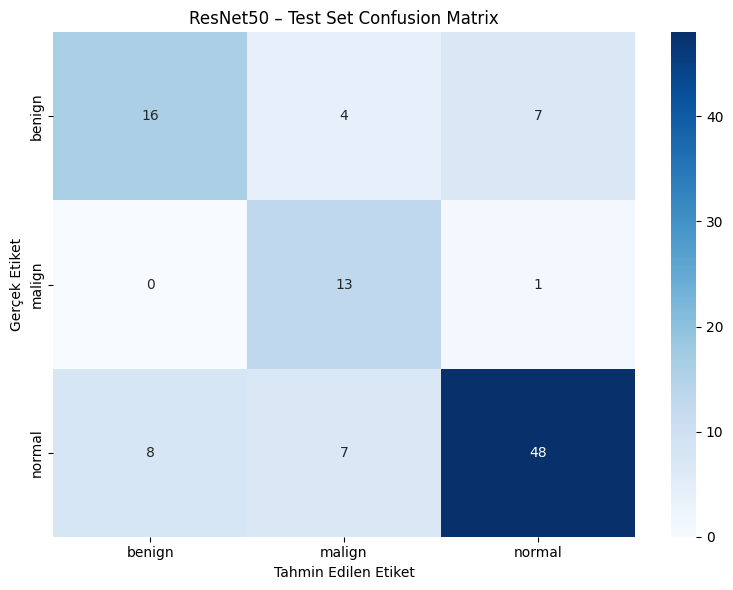

In [ ]:
# ================================
# DRIVE'DAN MODEL YÜKLE + TEST SET EVALUATION
# ================================

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Belleği temizle (önceki modeller karışmasın)
tf.keras.backend.clear_session()

# --- 1. MODELİ DRIVE'DAN YÜKLE ---
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/resnet50_uclm_tl(-4).keras"
model = load_model(model_path)
print("✅ Model Drive'dan yüklendi")

# --- 2. TEST VERİSİ (SADECE TEST) ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

test_dir = "/content/uclm_data/test"   # 🔴 NET: TEST KLASÖRÜ

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. TAHMİNLER ---
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# --- 4. METRİKLER ---
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_labels)

print("-" * 50)
print(f"✅ TEST SET Accuracy: %{acc * 100:.2f}")
print("-" * 50)
print("📊 Test Set Classification Report:")
print(report)

# --- 5. CONFUSION MATRIX (GÖRSEL) ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("ResNet50 – Test Set Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.tight_layout()
plt.show()


In [ ]:
import os
from collections import Counter

test_dir = "/content/uclm_data/test"

class_counts = {}

for class_name in sorted(os.listdir(test_dir)):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        class_counts[class_name] = len(image_files)

print("📊 Test datası – sınıf başına görüntü sayıları:")
print("-" * 45)

total = 0
for cls, count in class_counts.items():
    print(f"{cls:<15}: {count}")
    total += count

print("-" * 45)
print(f"Toplam test görüntüsü: {total}")


📊 Test datası – sınıf başına görüntü sayıları:
---------------------------------------------
benign         : 27
malign         : 14
normal         : 63
---------------------------------------------
Toplam test görüntüsü: 104


In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. AYARLAR ---
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
EXTRACT_PATH = '/content/uclm_tl_train'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NEW_LEARNING_RATE = 0.001 # LR 10^-5 olarak güncellendi
EPOCHS = 50

# --- 2. ZIP'TEN ÇIKARMA ---
if not os.path.exists(EXTRACT_PATH):
    print("📦 TL Verileri zip'ten çıkarılıyor...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ Çıkarma tamamlandı.")

# --- 3. VERİ YÜKLEYİCİLER ---
train_dir = os.path.join(EXTRACT_PATH, 'train')
val_dir = os.path.join(EXTRACT_PATH, 'val')

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 4. MODEL TANIMI (Fine-Tuning Modu) ---
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Son 20 katmanı eğitime açıyoruz
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('/content/best_resnet_tl.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

# --- 6. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"\n🚀 ResNet50 Fine-Tuning Başlıyor (Son 20 Katman Açık, LR: {NEW_LEARNING_RATE})...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# --- 7. DRIVE'A KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/"
if not os.path.exists(save_dir): os.makedirs(save_dir)

model_path = os.path.join(save_dir, "resnet50_uclm_tl(-3).keras")
model.save(model_path)
print(f"✅ Model kaydedildi: {model_path}")

Found 2121 images belonging to 3 classes.
Found 102 images belonging to 3 classes.

🚀 ResNet50 Fine-Tuning Başlıyor (Son 20 Katman Açık, LR: 0.001)...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.3901 - loss: 1.1936
Epoch 1: val_accuracy improved from -inf to 0.25490, saving model to /content/best_resnet_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 63s 730ms/step - accuracy: 0.3907 - loss: 1.1923 - val_accuracy: 0.2549 - val_loss: 18.9341 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5304 - loss: 1.0032
Epoch 2: val_accuracy did not improve from 0.25490
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 548ms/step - accuracy: 0.5307 - loss: 1.0027 - val_accuracy: 0.2549 - val_loss: 3.8088 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.5896 - loss: 0.8856
Epoch 3: val_accuracy did not improve from 0.25490
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 551ms/step - accuracy: 0.5895 - loss: 0.8857 - val_accuracy: 0.2549 - val_loss: 13.2502 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.6311 - loss: 0.7916
Epoch 4: val_accuracy impro

✅ Model Drive'dan yüklendi
Found 104 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
--------------------------------------------------
✅ TEST SET Accuracy: %73.08
--------------------------------------------------
📊 Test Set Classification Report:
              precision    recall  f1-score   support

      benign       0.75      0.33      0.46        27
      malign       0.67      0.71      0.69        14
      normal       0.74      0.90      0.81        63

    accuracy                           0.73       104
   macro avg       0.72      0.65      0.66       104
weighted avg       0.73      0.73      0.71       104



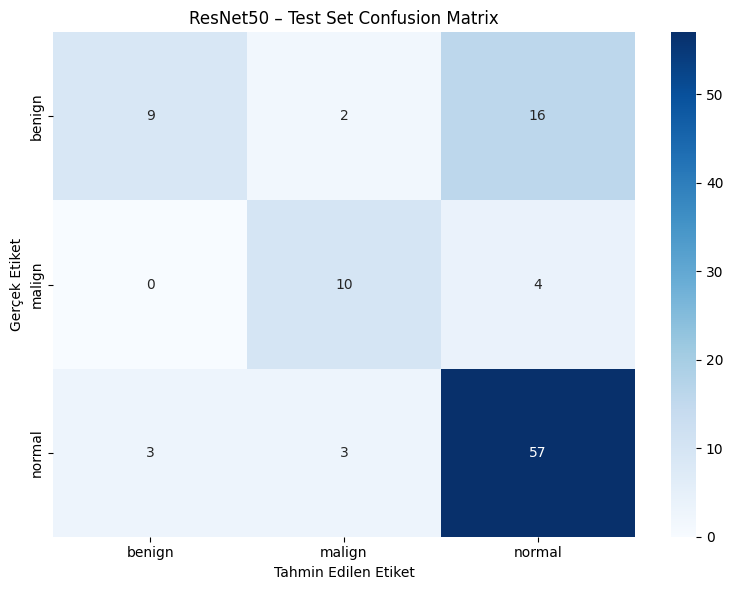

In [ ]:
# ================================
# DRIVE'DAN MODEL YÜKLE + TEST SET EVALUATION
# ================================

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Belleği temizle (önceki modeller karışmasın)
tf.keras.backend.clear_session()

# --- 1. MODELİ DRIVE'DAN YÜKLE ---
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/resnet50_uclm_tl(-3).keras"
model = load_model(model_path)
print("✅ Model Drive'dan yüklendi")

# --- 2. TEST VERİSİ (SADECE TEST) ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

test_dir = "/content/uclm_data/test"   # 🔴 NET: TEST KLASÖRÜ

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. TAHMİNLER ---
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# --- 4. METRİKLER ---
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_labels)

print("-" * 50)
print(f"✅ TEST SET Accuracy: %{acc * 100:.2f}")
print("-" * 50)
print("📊 Test Set Classification Report:")
print(report)

# --- 5. CONFUSION MATRIX (GÖRSEL) ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("ResNet50 – Test Set Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.tight_layout()
plt.show()


XCEPTION

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. AYARLAR ---
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
EXTRACT_PATH = '/content/uclm_tl_train'
IMAGE_SIZE = (299, 299) # Xception için standart boyut
BATCH_SIZE = 32
NEW_LEARNING_RATE = 0.00001
EPOCHS = 50

# --- 2. ZIP'TEN ÇIKARMA ---
if not os.path.exists(EXTRACT_PATH):
    print("📦 TL Verileri çıkarılıyor...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

# --- 3. VERİ YÜKLEYİCİLER (Xception Preprocess) ---
train_dir = os.path.join(EXTRACT_PATH, 'train')
val_dir = os.path.join(EXTRACT_PATH, 'val')

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 4. MODEL TANIMI (Xception Fine-Tuning) ---
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Son 20 katmanı açıyoruz
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('/content/best_xception_tl.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

# --- 6. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"\n🚀 Xception Fine-Tuning Başlıyor (Son 20 Katman Açık)...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# --- 7. DRIVE'A KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/"
if not os.path.exists(save_dir): os.makedirs(save_dir)

model_path = os.path.join(save_dir, "xception_uclm_tl(-5).keras")
model.save(model_path)
print(f"✅ Xception Model kaydedildi: {model_path}")

📦 TL Verileri çıkarılıyor...
Found 2121 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Xception Fine-Tuning Başlıyor (Son 20 Katman Açık)...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3649 - loss: 1.1098
Epoch 1: val_accuracy improved from -inf to 0.61765, saving model to /content/best_xception_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3654 - loss: 1.1095 - val_accuracy: 0.6176 - val_loss: 0.9548 - learning_rate: 1.0000e-05
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.5059 - loss: 1.0137
Epoch 2: val_accuracy improved from 0.61765 to 0.70588, saving model to /content/best_xception_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 586ms/step - accuracy: 0.5062 - loss: 1.0135 - val_accuracy: 0.7059 - val_loss: 0.7874 - learning_rate: 1.0000e-05
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.5810 - loss: 0.9400
Epoch 3: val_accuracy improved from 0.70588 to 0.76471, saving model to /content/best_xception_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 585ms/step - accuracy: 0.5813 - loss: 0.9396 - val_accuracy: 0.7647 - val_loss: 0.6917 - learning_rate: 1.0000e-05


✅ Model Drive'dan yüklendi
Found 104 images belonging to 3 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
--------------------------------------------------
✅ TEST SET Accuracy: %84.62
--------------------------------------------------
📊 Test Set Classification Report:
              precision    recall  f1-score   support

      benign       0.77      0.74      0.75        27
      malign       0.90      0.64      0.75        14
      normal       0.87      0.94      0.90        63

    accuracy                           0.85       104
   macro avg       0.85      0.77      0.80       104
weighted avg       0.85      0.85      0.84       104



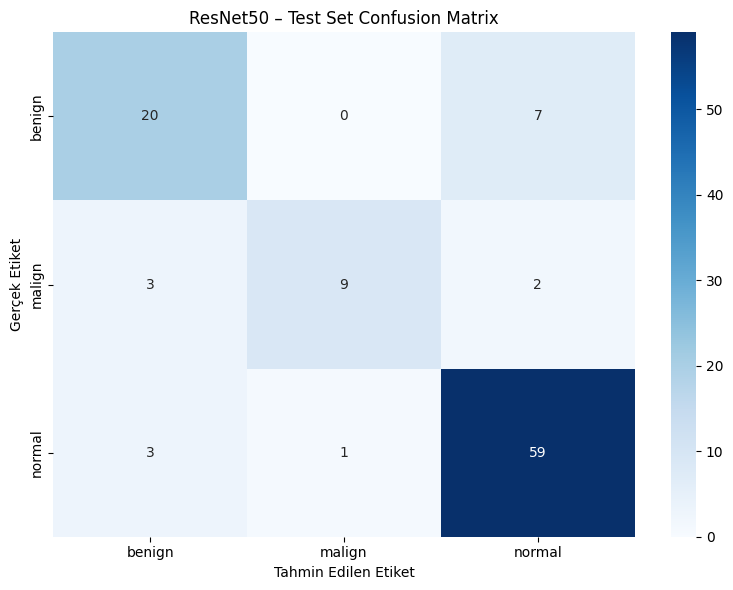

In [ ]:
# ================================
# DRIVE'DAN MODEL YÜKLE + TEST SET EVALUATION
# ================================

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Belleği temizle (önceki modeller karışmasın)
tf.keras.backend.clear_session()

# --- 1. MODELİ DRIVE'DAN YÜKLE ---
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/xception_uclm_tl(-5).keras"
model = load_model(model_path)
print("✅ Model Drive'dan yüklendi")

# --- 2. TEST VERİSİ (SADECE TEST) ---
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

test_dir = "/content/uclm_data/test"   # 🔴 NET: TEST KLASÖRÜ

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. TAHMİNLER ---
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# --- 4. METRİKLER ---
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_labels)

print("-" * 50)
print(f"✅ TEST SET Accuracy: %{acc * 100:.2f}")
print("-" * 50)
print("📊 Test Set Classification Report:")
print(report)

# --- 5. CONFUSION MATRIX (GÖRSEL) ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("ResNet50 – Test Set Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.tight_layout()
plt.show()


In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. AYARLAR ---
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
EXTRACT_PATH = '/content/uclm_tl_train'
IMAGE_SIZE = (299, 299) # Xception için standart boyut
BATCH_SIZE = 32
NEW_LEARNING_RATE = 0.00001
EPOCHS = 50

# --- 2. ZIP'TEN ÇIKARMA ---
if not os.path.exists(EXTRACT_PATH):
    print("📦 TL Verileri çıkarılıyor...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

# --- 3. VERİ YÜKLEYİCİLER (Xception Preprocess) ---
train_dir = os.path.join(EXTRACT_PATH, 'train')
val_dir = os.path.join(EXTRACT_PATH, 'val')

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 4. MODEL TANIMI (Xception Fine-Tuning) ---
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Son 20 katmanı açıyoruz
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('/content/best_xception_tl.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

# --- 6. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"\n🚀 Xception Fine-Tuning Başlıyor (Son 20 Katman Açık)...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# --- 7. DRIVE'A KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/"
if not os.path.exists(save_dir): os.makedirs(save_dir)

model_path = os.path.join(save_dir, "xception_uclm_tl(-3).keras")
model.save(model_path)
print(f"✅ Xception Model kaydedildi: {model_path}")

Found 2121 images belonging to 3 classes.
Found 102 images belonging to 3 classes.

🚀 Xception Fine-Tuning Başlıyor (Son 20 Katman Açık)...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.3202 - loss: 1.1242
Epoch 1: val_accuracy improved from -inf to 0.69608, saving model to /content/best_xception_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 78s 961ms/step - accuracy: 0.3209 - loss: 1.1239 - val_accuracy: 0.6961 - val_loss: 0.9406 - learning_rate: 1.0000e-05
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.4799 - loss: 1.0300
Epoch 2: val_accuracy improved from 0.69608 to 0.74510, saving model to /content/best_xception_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 589ms/step - accuracy: 0.4804 - loss: 1.0296 - val_accuracy: 0.7451 - val_loss: 0.7740 - learning_rate: 1.0000e-05
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.5979 - loss: 0.9352
Epoch 3: val_accuracy improved from 0.74510 to 0.77451, saving model to /content/best_xception_tl.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 591ms/step - accuracy: 0.5980 - loss: 0.9350 - val_accuracy: 0.7745 - val_loss: 0.6742 - learning_rate: 1.0000

✅ Model Drive'dan yüklendi
Found 104 images belonging to 3 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
--------------------------------------------------
✅ TEST SET Accuracy: %87.50
--------------------------------------------------
📊 Test Set Classification Report:
              precision    recall  f1-score   support

      benign       0.75      0.78      0.76        27
      malign       1.00      0.71      0.83        14
      normal       0.91      0.95      0.93        63

    accuracy                           0.88       104
   macro avg       0.89      0.81      0.84       104
weighted avg       0.88      0.88      0.87       104



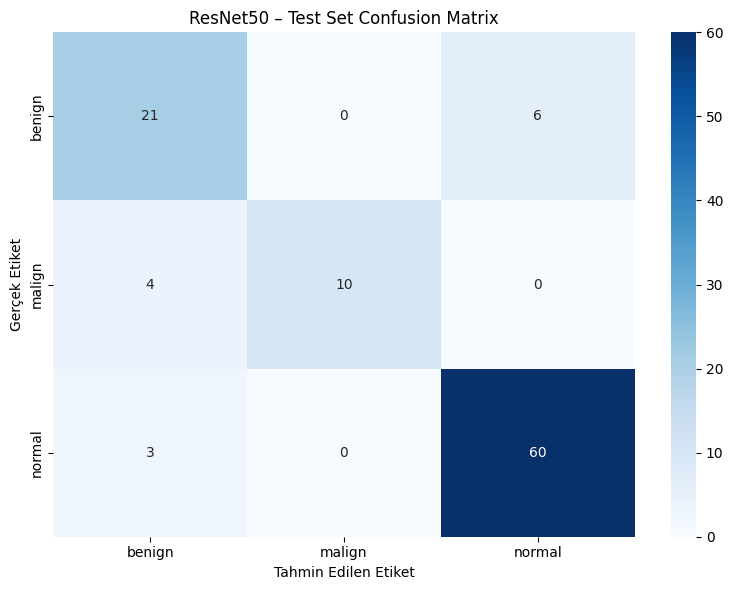

In [ ]:
# ================================
# DRIVE'DAN MODEL YÜKLE + TEST SET EVALUATION
# ================================

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Belleği temizle (önceki modeller karışmasın)
tf.keras.backend.clear_session()

# --- 1. MODELİ DRIVE'DAN YÜKLE ---
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/xception_uclm_tl(-3).keras"
model = load_model(model_path)
print("✅ Model Drive'dan yüklendi")

# --- 2. TEST VERİSİ (SADECE TEST) ---
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

test_dir = "/content/uclm_data/test"   # 🔴 NET: TEST KLASÖRÜ

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. TAHMİNLER ---
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# --- 4. METRİKLER ---
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_labels)

print("-" * 50)
print(f"✅ TEST SET Accuracy: %{acc * 100:.2f}")
print("-" * 50)
print("📊 Test Set Classification Report:")
print(report)

# --- 5. CONFUSION MATRIX (GÖRSEL) ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("ResNet50 – Test Set Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.tight_layout()
plt.show()


NASNET

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. AYARLAR ---
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
EXTRACT_PATH = '/content/uclm_tl_train'
IMAGE_SIZE = (331, 331)
BATCH_SIZE = 16
NEW_LEARNING_RATE = 0.0001
EPOCHS = 30

# --- 2. ZIP'TEN ÇIKARMA ---
if not os.path.exists(EXTRACT_PATH):
    print("📦 TL Verileri zip'ten çıkarılıyor...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ Çıkarma tamamlandı.")

# --- 3. VERİ YÜKLEYİCİLER (KRİTİK GÜNCELLEME: preprocess_input) ---
train_dir = os.path.join(EXTRACT_PATH, 'train')
val_dir = os.path.join(EXTRACT_PATH, 'val')

# rescale=1./255 yerine NASNet'in kendi ön işleme fonksiyonunu kullanıyoruz
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 4. MODEL TANIMI (Robust Mimari) ---
# Pooling='avg' yerine dışarıdan GlobalAverage ekleyerek modelin geneli görmesini sağlıyoruz
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Son 20 katman açık, gerisi donduruldu
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) # Açıkça Pooling ekledik
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('/content/best_nasnet_tl_robust.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

# --- 6. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"\n🚀 Robust NASNetLarge Fine-Tuning Başlıyor (Son 20 Katman Açık, LR: {NEW_LEARNING_RATE})...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# --- 7. DRIVE'A KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/NasNet_Results/"
if not os.path.exists(save_dir): os.makedirs(save_dir)

model_path = os.path.join(save_dir, "nasnetlarge_uclm_tl(-4).keras")
model.save(model_path)
print(f"✅ Robust Model kaydedildi: {model_path}")

Found 2121 images belonging to 3 classes.
Found 102 images belonging to 3 classes.

🚀 Robust NASNetLarge Fine-Tuning Başlıyor (Son 20 Katman Açık, LR: 0.0001)...

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.4588 - loss: 1.0617
Epoch 1: val_accuracy improved from -inf to 0.76471, saving model to /content/best_nasnet_tl_robust.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.4592 - loss: 1.0611 - val_accuracy: 0.7647 - val_loss: 0.6033 - learning_rate: 1.0000e-04
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6607 - loss: 0.7717
Epoch 2: val_accuracy improved from 0.76471 to 0.81373, saving model to /content/best_nasnet_tl_robust.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 43s 324ms/step - accuracy: 0.6609 - loss: 0.7716 - val_accuracy: 0.8137 - val_loss: 0.5402 - learning_rate: 1.0000e-04
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7324 - loss: 0.6513
Epoch 3: val_accuracy did not improve from 0.81373
133/133 ━━━━━

✅ Model Drive'dan yüklendi
Found 104 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 114s 18s/step
--------------------------------------------------
✅ TEST SET Accuracy: %75.00
--------------------------------------------------
📊 Test Set Classification Report:
              precision    recall  f1-score   support

      benign       0.77      0.37      0.50        27
      malign       0.67      0.57      0.62        14
      normal       0.76      0.95      0.85        63

    accuracy                           0.75       104
   macro avg       0.73      0.63      0.65       104
weighted avg       0.75      0.75      0.72       104



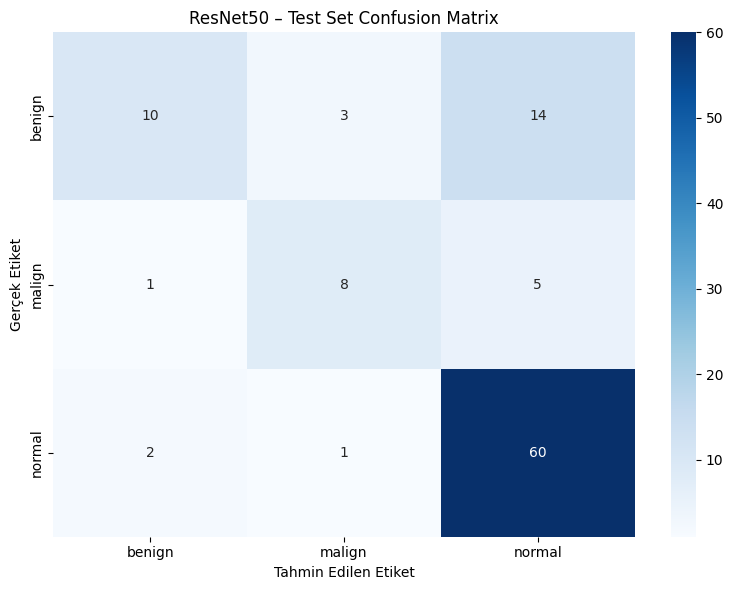

In [ ]:
# ================================
# DRIVE'DAN MODEL YÜKLE + TEST SET EVALUATION
# ================================

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Belleği temizle (önceki modeller karışmasın)
tf.keras.backend.clear_session()

# --- 1. MODELİ DRIVE'DAN YÜKLE ---
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/NasNet_Results/nasnetlarge_uclm_tl(-4).keras"
model = load_model(model_path)
print("✅ Model Drive'dan yüklendi")

# --- 2. TEST VERİSİ (SADECE TEST) ---
IMAGE_SIZE = (331, 331)
BATCH_SIZE = 32

test_dir = "/content/uclm_data/test"   # 🔴 NET: TEST KLASÖRÜ

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- 3. TAHMİNLER ---
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# --- 4. METRİKLER ---
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_labels)

print("-" * 50)
print(f"✅ TEST SET Accuracy: %{acc * 100:.2f}")
print("-" * 50)
print("📊 Test Set Classification Report:")
print(report)

# --- 5. CONFUSION MATRIX (GÖRSEL) ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("ResNet50 – Test Set Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.tight_layout()
plt.show()


In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. AYARLAR ---
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
EXTRACT_PATH = '/content/uclm_tl_train'
IMAGE_SIZE = (331, 331)
BATCH_SIZE = 16
NEW_LEARNING_RATE = 0.001
EPOCHS = 30

# --- 2. ZIP'TEN ÇIKARMA ---
if not os.path.exists(EXTRACT_PATH):
    print("📦 TL Verileri zip'ten çıkarılıyor...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ Çıkarma tamamlandı.")

# --- 3. VERİ YÜKLEYİCİLER (KRİTİK GÜNCELLEME: preprocess_input) ---
train_dir = os.path.join(EXTRACT_PATH, 'train')
val_dir = os.path.join(EXTRACT_PATH, 'val')

# rescale=1./255 yerine NASNet'in kendi ön işleme fonksiyonunu kullanıyoruz
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- 4. MODEL TANIMI (Robust Mimari) ---
# Pooling='avg' yerine dışarıdan GlobalAverage ekleyerek modelin geneli görmesini sağlıyoruz
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Son 20 katman açık, gerisi donduruldu
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) # Açıkça Pooling ekledik
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('/content/best_nasnet_tl_robust.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

# --- 6. DERLEME VE EĞİTİM ---
model.compile(optimizer=Adam(learning_rate=NEW_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"\n🚀 Robust NASNetLarge Fine-Tuning Başlıyor (Son 20 Katman Açık, LR: {NEW_LEARNING_RATE})...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# --- 7. DRIVE'A KAYDETME ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/NasNet_Results/"
if not os.path.exists(save_dir): os.makedirs(save_dir)

model_path = os.path.join(save_dir, "nasnetlarge_uclm_tl(-3).keras")
model.save(model_path)
print(f"✅ Robust Model kaydedildi: {model_path}")